# Anomaly Detection

En este ejemplo se usa la famosa base de datos [MNIST](https://en.wikipedia.org/wiki/MNIST_database) que tiene en letra manuscrita los 10 dígitos (0,1,...9). Se entrena el modelo para que el '0' sea la clase "normal", y todo el resto de dígitos sea considerado como "anomalía".

Implementacion basada en [f-AnoGan](http://github.com/dbbbbm/f-AnoGAN-PyTorch)

Esta umplementación ocupa como entrada imágenes de 3 canales de color de 64x64 pixeles. En caso de querer usar otras imágenes cambiar la función one_class_dataloader en F-AnoGan. En caso de querer usar otra dimensión de imágenes debería funcionar cambiando DIM y OUTpUT_DIM en WGAN 64x64.

Adaptación hecha por Joaquín Hofmann y Domingo Mery

Referencia:
Schlegl, T., Seeböck, P., Waldstein, S. M., Langs, G., & Schmidt-Erfurth, U. (2019). [f-AnoGAN: Fast unsupervised anomaly detection with generative adversarial networks](https://www.sciencedirect.com/science/article/abs/pii/S1361841518302640). Medical image analysis, 54, 30-44.

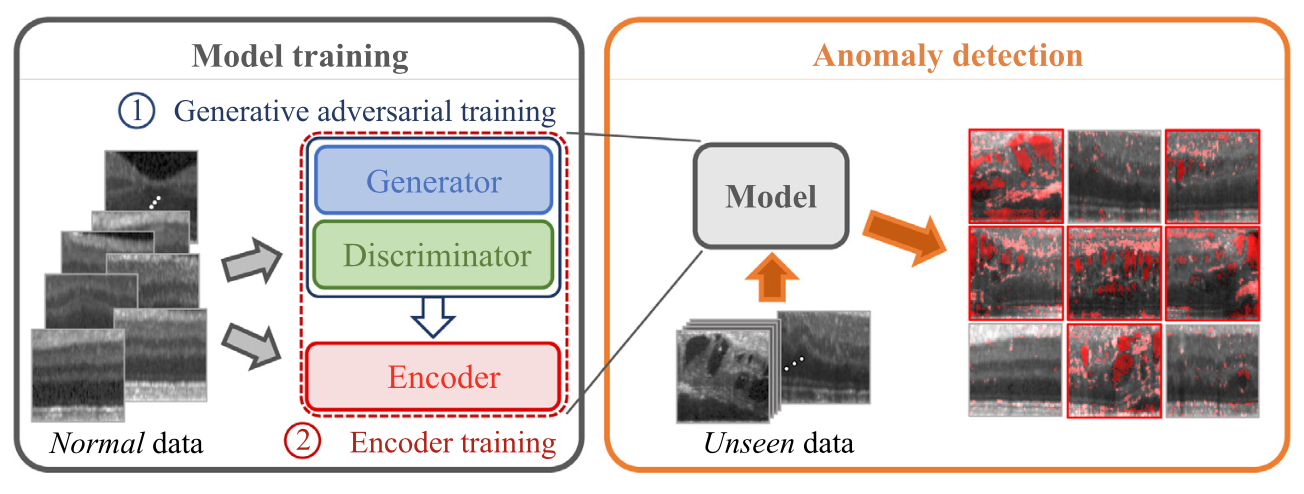

In [1]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"]= "max_split_size_mb:21"
key = "PYTORCH_CUDA_ALLOC_CONF"
value = os.getenv(key)

print(value)

max_split_size_mb:21


# Some functions

In [2]:
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

# WGAN 64x64

In [3]:
# wgan64x64.py
from torch import nn
from torch.autograd import grad
import torch
DIM = 160
OUTPUT_DIM = 3*160*160

class MyConvo2d(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True,  stride=1, bias=True):
        super(MyConvo2d, self).__init__()
        self.he_init = he_init
        self.padding = int((kernel_size - 1)/2)
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size,
                              stride=1, padding=self.padding, bias=bias)

    def forward(self, input):
        output = self.conv(input)
        return output


class ConvMeanPool(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(ConvMeanPool, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init)

    def forward(self, input):
        output = self.conv(input)
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] +
                  output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        return output


class MeanPoolConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(MeanPoolConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init)

    def forward(self, input):
        output = input
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] +
                  output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        output = self.conv(output)
        return output


class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size*block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, input_height, input_width, input_depth) = output.size()
        output_depth = int(input_depth / self.block_size_sq)
        output_width = int(input_width * self.block_size)
        output_height = int(input_height * self.block_size)
        t_1 = output.reshape(batch_size, input_height,
                             input_width, self.block_size_sq, output_depth)
        spl = t_1.split(self.block_size, 3)
        stacks = [t_t.reshape(batch_size, input_height,
                              output_width, output_depth) for t_t in spl]
        output = torch.stack(stacks, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(
            batch_size, output_height, output_width, output_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class UpSampleConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True, bias=True):
        super(UpSampleConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init, bias=bias)
        self.depth_to_space = DepthToSpace(2)

    def forward(self, input):
        output = input
        output = torch.cat((output, output, output, output), 1)
        output = self.depth_to_space(output)
        output = self.conv(output)
        return output


class ResidualBlock(nn.Module):
    # ResidualBlock(dim, dim*2, 3, 'down', 64)
    def __init__(self, input_dim, output_dim, kernel_size, resample=None, hw=DIM):
        super(ResidualBlock, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.resample = resample
        self.bn1 = None
        self.bn2 = None
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        if resample == 'down':
            self.bn1 = nn.LayerNorm([input_dim, hw, hw])
            self.bn2 = nn.LayerNorm([input_dim, hw, hw])
        elif resample == 'up':
            self.bn1 = nn.BatchNorm2d(input_dim)
            self.bn2 = nn.BatchNorm2d(output_dim)
        elif resample == None:
            # TODO: ????
            self.bn1 = nn.BatchNorm2d(output_dim)
            self.bn2 = nn.LayerNorm([input_dim, hw, hw])
        else:
            raise Exception('invalid resample value')

        if resample == 'down':
            self.conv_shortcut = MeanPoolConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(
                input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = ConvMeanPool(
                input_dim, output_dim, kernel_size=kernel_size)
        elif resample == 'up':
            self.conv_shortcut = UpSampleConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = UpSampleConv(
                input_dim, output_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(
                output_dim, output_dim, kernel_size=kernel_size)
        elif resample == None:
            self.conv_shortcut = MyConvo2d(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(
                input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(
                input_dim, output_dim, kernel_size=kernel_size)
        else:
            raise Exception('invalid resample value')

    def forward(self, input):
        if self.input_dim == self.output_dim and self.resample == None:
            shortcut = input
        else:
            shortcut = self.conv_shortcut(input)

        output = input
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.conv_1(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.conv_2(output)

        return shortcut + output


class ReLULayer(nn.Module):
    def __init__(self, n_in, n_out):
        super(ReLULayer, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.linear = nn.Linear(n_in, n_out)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.linear(input)
        output = self.relu(output)
        return output


class FCGenerator(nn.Module):
    def __init__(self, FC_DIM=512):
        super(FCGenerator, self).__init__()
        self.relulayer1 = ReLULayer(128, FC_DIM)
        self.relulayer2 = ReLULayer(FC_DIM, FC_DIM)
        self.relulayer3 = ReLULayer(FC_DIM, FC_DIM)
        self.relulayer4 = ReLULayer(FC_DIM, FC_DIM)
        self.linear = nn.Linear(FC_DIM, OUTPUT_DIM)
        self.tanh = nn.Tanh()

    def forward(self, input):
        output = self.relulayer1(input)
        output = self.relulayer2(output)
        output = self.relulayer3(output)
        output = self.relulayer4(output)
        output = self.linear(output)
        output = self.tanh(output)
        return output


class GoodGenerator(nn.Module):
    def __init__(self, dim=DIM, output_dim=OUTPUT_DIM):
        super(GoodGenerator, self).__init__()

        self.dim = dim

        # self.ln1 = nn.Linear(128, 4*4*8*self.dim)
        self.ln1 = nn.Linear(128, 10*10*8*self.dim)
        self.rb1 = ResidualBlock(8*self.dim, 8*self.dim, 3, resample='up')
        self.rb2 = ResidualBlock(8*self.dim, 4*self.dim, 3, resample='up')
        self.rb3 = ResidualBlock(4*self.dim, 2*self.dim, 3, resample='up')
        self.rb4 = ResidualBlock(2*self.dim, 1*self.dim, 3, resample='up')
        self.bn = nn.BatchNorm2d(self.dim)

        self.conv1 = MyConvo2d(1*self.dim, 3, 3)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # print("PEROFORMING __init__")
        self.initialize()

    def initialize(self):
        # print("PEROFORMING INITIALIZATION")
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, input):
        # print("PEROFORMING FORWARD FUNCTION")
        # print("input shape is: ", input.shape)
        output = self.ln1(input.contiguous())
        # print("self.ln1 shape is: ", output.shape)
        # output = output.view(-1, 8*self.dim, 4, 4)
        output = output.view(-1, 8*self.dim, 10, 10)
        # print("output.view shape is: ", output.shape)
        output = self.rb1(output)
        # print("self.rb1 shape is: ", output.shape)
        output = self.rb2(output)
        # print("self.rb2 shape is: ", output.shape)
        output = self.rb3(output)
        # print("self.rb3 shape is: ", output.shape)
        output = self.rb4(output)
        # print("self.rb4 shape is: ", output.shape)

        output = self.bn(output)
        # print("self.bn shape is: ", output.shape)
        output = self.relu(output)
        # print("self.relu shape is: ", output.shape)
        output = self.conv1(output)
        # print("self.conv1 shape is: ", output.shape)
        output = self.tanh(output)
        # print("self.tanh shape is: ", output.shape)
        # print("END OF FORWARD FUNCTION")
        # # output = output.view(-1, OUTPUT_DIM)
        return output




class GoodDiscriminator(nn.Module):
    def __init__(self, dim=DIM):
        super(GoodDiscriminator, self).__init__()

        self.dim = dim

        self.conv1 = MyConvo2d(3, self.dim, 3, he_init=False)
        self.rb1 = ResidualBlock(self.dim, 2*self.dim,
                                 3, resample='down', hw=DIM)
        self.rb2 = ResidualBlock(
            2*self.dim, 4*self.dim, 3, resample='down', hw=int(DIM/2))
        self.rb3 = ResidualBlock(
            4*self.dim, 8*self.dim, 3, resample='down', hw=int(DIM/4))
        self.rb4 = ResidualBlock(
            8*self.dim, 8*self.dim, 3, resample='down', hw=int(DIM/8))
        # self.ln1 = nn.Linear(4*4*8*self.dim, 1)
        self.ln1 = nn.Linear(10*10*8*self.dim, 1)
        # print("PEROFORMING __init__")
        self.initialize()

    def initialize(self):
        # print("PEROFORMING INITIALIZATION")
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def extract_feature(self, input):
        # print("PEROFORMING EXTRACTING FEATURES FUNCTION")
        # print("input shape is: ", input.shape)
        output = input.contiguous()
        # print("input.contigous() shape is: ", output.shape)
        output = output.view(-1, 3, DIM, DIM)
        # print("new shape of output is: ", output.shape)
        output = self.conv1(output)
        # print("after self.conv1, the shape of output is: ", output.shape)
        output = self.rb1(output)
        # print("after self.rb1, the shape of output is: ", output.shape)
        output = self.rb2(output)
        # print("after self.rb2, the shape of output is: ", output.shape)
        output = self.rb3(output)
        # print("after self.rb3, the shape of output is: ", output.shape)
        output = self.rb4(output)
        # print("after self.rb4, the shape of output is: ", output.shape)
        # output = output.view(-1, 4*4*8*self.dim)
        output = output.view(-1, 10*10*8*self.dim)
        # print("after output.view, the shape of output is: ", output.shape)
        # print("END OF THE EXTRACTING FEATURES FUNCTION")  
        return output

    def forward(self, input):
        output = self.extract_feature(input)
        output = self.ln1(output)
        output = output.view(-1)
        # print("PEROFORMING FORWARD")
        return output





class Encoder(nn.Module):
    def __init__(self, dim, output_dim, drop_rate=0.0):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(drop_rate)
        self.conv_in = nn.Conv2d(3, dim, 3, 1, padding=1)
        # self.res1 = ResidualBlock(dim, dim*2, 3, 'down', 64)
        # self.res2 = ResidualBlock(dim*2, dim*4, 3, 'down', 32)
        # self.res3 = ResidualBlock(dim*4, dim*8, 3, 'down', 16)
        # self.res4 = ResidualBlock(dim*8, dim*8, 3, 'down', 8)
        self.res1 = ResidualBlock(dim, dim*2, 3, 'down', 160)
        self.res2 = ResidualBlock(dim*2, dim*4, 3, 'down', 80)
        self.res3 = ResidualBlock(dim*4, dim*8, 3, 'down', 40)
        self.res4 = ResidualBlock(dim*8, dim*8, 3, 'down', 20)
        # self.fc = nn.Linear(4*4*8*dim, output_dim)
        self.fc = nn.Linear(10*10*8*dim, output_dim)


    def forward(self, x):
        # print("PEROFORMING FORWARD FUNCTION")
        # print("x shape is: ", x.shape)
        x = self.dropout(x)
        # print("self.dropout shape is: ", x.shape)
        x = self.conv_in(x)
        # print("self.conv_in shape is: ", x.shape)
        x = self.res1(x)
        # print("self.res1 shape is: ", x.shape)
        x = self.res2(x)
        # print("self.res2 shape is: ", x.shape)
        x = self.res3(x)
        # print("self.res3 shape is: ", x.shape)
        x = self.res4(x)
        # print("self.res4 shape is: ", x.shape)
        x = x.view(x.size(0), -1)
        # print("self.view shape is: ", x.shape)
        x = self.fc(x)
        # print("self.fc shape is: ", x.shape)
        # print("torch.tanh(x) shape is: ", torch.tanh(x).shape)
        return torch.tanh(x)

# F-AnoGan

In [4]:
from torch.utils.data import DataLoader
from torch import optim
from torch import autograd
from torch import nn
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import sampler
from argparse import ArgumentParser
#from wgan64x64 import *
from sklearn import metrics
import torch
from tqdm.auto import tqdm
import numpy as np
import time
import os
import sys
import random
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
sys.path.append(os.getcwd())

MODE = 'wgan-gp'  # Valid options are dcgan, wgan, or wgan-gp

LAMBDA = 10  # Gradient penalty lambda hyperparameter
CRITIC_ITERS = 5  # How many critic iterations per generator iteration
BATCH_SIZE = 5  # Batch size

NOISE_SIZE = 128
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.determinstic = False

def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(BATCH_SIZE, int(real_data.nelement()/BATCH_SIZE)).contiguous()
    alpha = alpha.view(BATCH_SIZE, 3, DIM, DIM)
    alpha = alpha.to(device)

    fake_data = fake_data.view(BATCH_SIZE, 3, DIM, DIM)
    # interpolates = alpha * real_data.cuda().detach() + ((1 - alpha) * fake_data.detach())           # For home laptop. GPU capabilites
    interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())                # For work laptop. No GPU
    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(
                                  disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

def one_class_dataloader(c, nw=0, bs=64):

    nw = 0

    # data_dir = '../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop
    # test_dir = '../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
    data_dir = '../../../BottleStoodUp_atNight/Positive'      #This is for the work laptop
    test_dir = '../../../BottleStoodUp_atNight/Evaluation'      


    transform = transforms.Compose([
            # transforms.RandomCrop(32, padding=4),
            # transforms.RandomHorizontalFlip(),
            transforms.Resize(255),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5),
            #                      (0.5, 0.5, 0.5)),
        ])

    dataset = datasets.ImageFolder(data_dir, transform = transform)
    trainloader = DataLoader(
        dataset, bs, num_workers=nw, pin_memory=True, drop_last=True) 
    
    dataset_test = datasets.ImageFolder(test_dir, transform = transform)
    dataloader_test = DataLoader(
        dataset_test, bs, num_workers=nw, pin_memory=True, drop_last=False) 


    return trainloader, dataloader_test


def wgan_training(PreTrained=False,saveat=1000,genstart=0):
    netG = GoodGenerator().to(device)
    netD = GoodDiscriminator().to(device)
    if PreTrained: 
      print('loading pretrained discriminator-weights '+D_Model+'...')
      netD.load_state_dict(torch.load(D_Model))
      print('loading pretrained generator-weights '+G_Model+'...')
      netG.load_state_dict(torch.load(G_Model))

    #one = torch.FloatTensor([1]).to(device)
    one = torch.tensor(1, dtype=torch.float).to(device)
    mone = one * -1

    optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.0, 0.9))
    optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.0, 0.9))

    dataloader, _ = one_class_dataloader(options_c, 0, BATCH_SIZE)
    D_real_list = []
    D_fake_list = []
    D_cost_list = []
    G_cost_list = []
    for iteration in tqdm(range(1+genstart, WGAN_ITERS + 1)):
        #print('WGAN - Iteration:'+str(iteration))
        start_time = time.time()
        ############################
        # (1) Update D network
        ###########################
        for i, (_data, _) in enumerate(dataloader):
            if i == CRITIC_ITERS:
                break
            netD.zero_grad()

            # train with real

            real_data = _data.to(device)
            imgs_croped = transforms.functional.crop(real_data.cuda(), 60, 30, 160, 160)

            D_real = netD(imgs_croped.cuda())
            D_real = D_real.mean()
            D_real.backward(mone)
            D_real_list.append(D_real.item())

            # train with fake
            noise = torch.randn(BATCH_SIZE, NOISE_SIZE)
            noise = noise.to(device)
            fake = netG(noise).detach()
            inputv = fake
            D_fake = netD(inputv)
            D_fake = D_fake.mean()
            D_fake.backward(one)
            D_fake_list.append(D_fake.item())

            # train with gradient penalty
            gradient_penalty = calc_gradient_penalty(netD, imgs_croped.data, fake.data)
            gradient_penalty.backward()

            # print "gradien_penalty: ", gradient_penalty

            D_cost = D_fake - D_real + gradient_penalty
            D_cost_list.append(D_cost.item())
            Wasserstein_D = D_real - D_fake
            optimizerD.step()
        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()

        noise = torch.randn(BATCH_SIZE, 128)
        noise = noise.to(device)
        fake = netG(noise)
        G = netD(fake)
        G = G.mean()
        G.backward(mone)
        G_cost = -G
        optimizerG.step()
        G_cost_list.append(G_cost.item())

        # Write logs and save samples

        if iteration % saveat == 0:
            save_image(fake*0.5+0.5, 'ForBottlesTrainigs/wgangp/fake_' + num2fixstr(iteration,5) + '.jpg')
            print('Iters:{}, D(real):{}, D(fake):{}, Loss D:{}, Loss G:{}'.format(
                iteration,
                np.mean(D_real_list),
                np.mean(D_fake_list),
                np.mean(D_cost_list),
                np.mean(G_cost_list),)
            )
        if iteration % saveat == 0 and iteration != 0:
            torch.save(netD.state_dict(), 'ForBottlesTrainigs/models/netD_' + num2fixstr(iteration,5) + '.pth')
            torch.save(netG.state_dict(), 'ForBottlesTrainigs/models/netG_' + num2fixstr(iteration,5) + '.pth')
    
def train_encoder(PreTrained=False,saveat=100,genstart=0):
    netG = GoodGenerator().to(device)
    # netG.load_state_dict(torch.load(G_Model))                                     #For home laptop, using GPU
    netG.load_state_dict(torch.load(G_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netG.eval()
    netD = GoodDiscriminator().to(device)
    # netD.load_state_dict(torch.load(D_Model))
    netD.load_state_dict(torch.load(D_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netD.eval()
    for p in netD.parameters():
        p.requires_grad = False
    for p in netG.parameters():
        p.requires_grad = False

    dataloader, _ = one_class_dataloader(options_c, 0, BATCH_SIZE)

    netE = Encoder(DIM, NOISE_SIZE).to(device)
    if PreTrained:
      netE.load_state_dict(torch.load(E_Model))

    optimizer = optim.Adam(netE.parameters(), 1e-4, (0.0, 0.9))

    crit = nn.MSELoss()
    # torch.cuda.empty_cache()

    for iteration in tqdm(range(1+genstart, ENCODER_ITERS+1)):
        losses = []
        netE.train()
        print("iteration is: ", iteration)
        i=0
        for (x, _) in dataloader:
            x = x.to(device)
            imgs_croped = transforms.functional.crop(x, 60, 30, 160, 160)
            code = netE(imgs_croped) 
            rec_image = netG(code)
            d_input = torch.cat((imgs_croped, rec_image), dim=0)
            f_x, f_gx = netD.extract_feature(d_input).chunk(2, 0)
            loss = crit(rec_image, imgs_croped) + options_alpha * crit(f_gx, f_x.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            print(i)
            i=i+1
        print(iteration, np.mean(losses))
        netE.eval()
        rec_image = netG(netE(imgs_croped))
        d_input = torch.cat((imgs_croped, rec_image), dim=0)
        
        if iteration % saveat == 0:
            save_image(d_input*0.5+0.5, 'ForBottlesTrainings/rec/rec_'+num2fixstr(iteration,4)+'.png')
        if iteration % saveat == 0 and iteration != 0:
            torch.save(netE.state_dict(), 'ForBottlesTrainings/models/netE_' + num2fixstr(iteration,5) + '.pth')
    torch.save(netE.state_dict(), 'ForBottlesTrainings/models/netE.pth')


c:\Users\Alex\.conda\envs\tfm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initial Settings

In [5]:
!mkdir wgangp
!mkdir rec
!mkdir models

Ya existe el subdirectorio o el archivo wgangp.
Ya existe el subdirectorio o el archivo rec.
Ya existe el subdirectorio o el archivo models.


In [6]:
options_c     = 0 # <- normal class
options_alpha = 1
options_cuda  = '0'
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
        torch.cuda.set_device('cuda:{}'.format(options_cuda))
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

# device2 = torch.device('cuda:{}'.format(options_cuda))
# torch.cuda.set_device('cuda:{}'.format(options_cuda))

cpu


In [7]:
print(torch.cuda.is_available())

False


# Training WGAN

In [8]:
genstart   = 0 # generación de partida (en caso de existir entrenamiento previo)
G_Model    = 'ForBottlesTrainings/models/netG_' + num2fixstr(genstart,5) + '.pth'
D_Model    = 'ForBottlesTrainings/models/netD_' + num2fixstr(genstart,5) + '.pth'

saveat     = 50   # cada cuantas iteraciones se guarda modelo
WGAN_ITERS = 100  # iteraciones máximas del entrenamiento

pretrained = genstart>0


In [9]:
# wgan_training(PreTrained=pretrained,saveat=saveat,genstart=genstart)

# Training Encoder-Decoder

In [10]:
encstart      = 0
ENCODER_ITERS = 20
saveat        = 10 # cada cuantas iteraciones se guarda modelo

gen           = WGAN_ITERS #generación del generator a usar
G_Model       = 'ForBottlesTrainings/models/netG_' + num2fixstr(gen,5) + '.pth'
D_Model       = 'ForBottlesTrainings/models/netD_' + num2fixstr(gen,5) + '.pth'
E_Model       = 'ForBottlesTrainings/models/netE_' + num2fixstr(encstart,5) + '.pth'

pretrained    = encstart>0

In [11]:

# train_encoder(PreTrained=pretrained,saveat=saveat)

# Evaluation

In [12]:
Ggen    = WGAN_ITERS #generación del generator a usar del generator
Egen    = ENCODER_ITERS #generación a usar del Encoder

G_Model = 'ForBottlesTrainings/models/netG_' + num2fixstr(Ggen,5) + '.pth'
D_Model = 'ForBottlesTrainings/models/netD_' + num2fixstr(Ggen,5) + '.pth'
E_Model = 'ForBottlesTrainings/models/netE.pth'




In [15]:
print(G_Model)
print(D_Model)

ForBottlesTrainings/models/netG_00100.pth
ForBottlesTrainings/models/netD_00100.pth


## Testing the "evaluate()" function, step by step

In [13]:
netG = GoodGenerator().to(device)
# netG.load_state_dict(torch.load(G_Model))                                     #For home laptop, using GPU
netG.load_state_dict(torch.load(G_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netG.eval()
netD = GoodDiscriminator().to(device)
# netD.load_state_dict(torch.load(D_Model))                                     #For home laptop, using GPU
netD.load_state_dict(torch.load(D_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netD.eval()
netE = Encoder(DIM, NOISE_SIZE).to(device)
# netE.load_state_dict(torch.load(E_Model))                                     #For home laptop, using GPU
netE.load_state_dict(torch.load(E_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netE.eval()

_, dataloader = one_class_dataloader(options_c, 0, BATCH_SIZE)


Dataloader is the container of all the batches of images. It also corresponds to the test images. 

In [14]:
print(len(dataloader))

6


In [15]:
images, labels = next(iter(dataloader))
print(len(images))
print(images[0].shape)

5
torch.Size([3, 224, 224])


In [16]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        print("this is x: ", len(label))
        print("This is the first element of the label variable", label[0])
        

  0%|          | 0/6 [00:00<?, ?it/s]

this is x:  5
This is the first element of the label variable tensor(0)


 33%|███▎      | 2/6 [00:00<00:00, 12.71it/s]

this is x:  5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(0)


 67%|██████▋   | 4/6 [00:00<00:00, 12.59it/s]

this is x:  5
This is the first element of the label variable tensor(0)


100%|██████████| 6/6 [00:00<00:00, 12.20it/s]

this is x:  5
This is the first element of the label variable tensor(0)
this is x:  5
This is the first element of the label variable tensor(1)


Above we can see the first label element of all the batches in the test set

In [18]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        x = x.to(device)                        # Taking the entire batch to the available device
        imgs_croped = transforms.functional.crop(x, 60, 30, 160, 160)
        if i == 0:
            print("this is the shape of the images that will be fed to the enocder model: ", x.shape)
            aux = netE(imgs_croped)
            # print("this is aux: ", aux)
        i = i+1
        
print("this is the shape of the output of the enconder model: ", aux.shape)
# print("This is the shape of the first element of the aux variable", aux[0].shape)

  0%|          | 0/6 [00:00<?, ?it/s]

this is the shape of the images that will be fed to the enocder model:  torch.Size([5, 3, 224, 224])


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

this is the shape of the output of the enconder model:  torch.Size([5, 128])


In [19]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        x = x.to(device)                        # Taking the entire batch to the available device
        imgs_croped = transforms.functional.crop(x, 60, 30, 160, 160)
        if i == 0:
            rec_image = netG(netE(imgs_croped)) 
            # print("this is aux: ", aux)
        i = i+1
        
print("this is the shape of the output of the generator model: ", rec_image.shape)

100%|██████████| 6/6 [00:07<00:00,  1.21s/it]

this is the shape of the output of the generator model:  torch.Size([5, 3, 160, 160])


In [20]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        x = x.to(device)                        # Taking the entire batch to the available device
        imgs_croped = transforms.functional.crop(x, 60, 30, 160, 160)
        if i == 0:
            rec_image = netG(netE(imgs_croped)) 
            d_input       = torch.cat((imgs_croped, rec_image), dim=0)   
            print("this is d_input: ", d_input)
        i = i+1
        
print("this is the shape of d_input, the concatenation of x and rec_image: ", d_input.shape)

 50%|█████     | 3/6 [00:06<00:05,  1.82s/it]

this is d_input:  tensor([[[[ 0.6471,  0.6510,  0.6588,  ...,  0.5608,  0.5490,  0.5451],
          [ 0.6510,  0.6510,  0.6627,  ...,  0.5725,  0.5529,  0.5451],
          [ 0.6510,  0.6510,  0.6627,  ...,  0.5608,  0.5490,  0.5490],
          ...,
          [ 0.3098,  0.3098,  0.3059,  ...,  0.2392,  0.2549,  0.2667],
          [ 0.3059,  0.3098,  0.2980,  ...,  0.2392,  0.2431,  0.2588],
          [ 0.3059,  0.3059,  0.2980,  ...,  0.2510,  0.2549,  0.2431]],

         [[ 0.6471,  0.6510,  0.6588,  ...,  0.5608,  0.5490,  0.5451],
          [ 0.6510,  0.6510,  0.6627,  ...,  0.5725,  0.5529,  0.5451],
          [ 0.6510,  0.6510,  0.6627,  ...,  0.5608,  0.5490,  0.5490],
          ...,
          [ 0.3098,  0.3098,  0.3059,  ...,  0.2392,  0.2549,  0.2667],
          [ 0.3059,  0.3098,  0.2980,  ...,  0.2392,  0.2431,  0.2588],
          [ 0.3059,  0.3059,  0.2980,  ...,  0.2510,  0.2549,  0.2431]],

         [[ 0.6471,  0.6510,  0.6588,  ...,  0.5608,  0.5490,  0.5451],
          [ 

100%|██████████| 6/6 [00:07<00:00,  1.19s/it]

this is the shape of d_input, the concatenation of x and rec_image:  torch.Size([10, 3, 160, 160])


Looking at the content of the image from the test set and its generated image:

In [21]:
images, labels = next(iter(dataloader))
images = images.to(device)                        # Taking the entire batch to the available device
imgs_croped = transforms.functional.crop(images, 60, 30, 160, 160)
print("These are the values of the batch of images:", imgs_croped)
print(imgs_croped.shape)

These are the values of the batch of images: tensor([[[[0.6471, 0.6510, 0.6588,  ..., 0.5608, 0.5490, 0.5451],
          [0.6510, 0.6510, 0.6627,  ..., 0.5725, 0.5529, 0.5451],
          [0.6510, 0.6510, 0.6627,  ..., 0.5608, 0.5490, 0.5490],
          ...,
          [0.3098, 0.3098, 0.3059,  ..., 0.2392, 0.2549, 0.2667],
          [0.3059, 0.3098, 0.2980,  ..., 0.2392, 0.2431, 0.2588],
          [0.3059, 0.3059, 0.2980,  ..., 0.2510, 0.2549, 0.2431]],

         [[0.6471, 0.6510, 0.6588,  ..., 0.5608, 0.5490, 0.5451],
          [0.6510, 0.6510, 0.6627,  ..., 0.5725, 0.5529, 0.5451],
          [0.6510, 0.6510, 0.6627,  ..., 0.5608, 0.5490, 0.5490],
          ...,
          [0.3098, 0.3098, 0.3059,  ..., 0.2392, 0.2549, 0.2667],
          [0.3059, 0.3098, 0.2980,  ..., 0.2392, 0.2431, 0.2588],
          [0.3059, 0.3059, 0.2980,  ..., 0.2510, 0.2549, 0.2431]],

         [[0.6471, 0.6510, 0.6588,  ..., 0.5608, 0.5490, 0.5451],
          [0.6510, 0.6510, 0.6627,  ..., 0.5725, 0.5529, 0.5451

In [22]:
rec_image = netG(netE(imgs_croped)) 
print("These are the values of the generated images:", rec_image)
print(rec_image.shape)

These are the values of the generated images: tensor([[[[ 0.5493,  0.6804,  0.6965,  ...,  0.5477,  0.5383,  0.5461],
          [ 0.7455,  0.8497,  0.8575,  ...,  0.7137,  0.7197,  0.6510],
          [ 0.7463,  0.8486,  0.8577,  ...,  0.7132,  0.7239,  0.6552],
          ...,
          [-0.0035,  0.6028,  0.4351,  ...,  0.3936,  0.4978, -0.1826],
          [-0.0255,  0.6291,  0.4754,  ...,  0.4144,  0.5237, -0.1908],
          [-0.0265,  0.3704,  0.2484,  ...,  0.2987,  0.4138, -0.0971]],

         [[ 0.6901,  0.8076,  0.8080,  ...,  0.6901,  0.6993,  0.4962],
          [ 0.7188,  0.8483,  0.8465,  ...,  0.6882,  0.6942,  0.6221],
          [ 0.7191,  0.8528,  0.8451,  ...,  0.6972,  0.6977,  0.6298],
          ...,
          [-0.9241, -0.9651, -0.9842,  ...,  0.6188,  0.7066,  0.5730],
          [-0.9345, -0.9709, -0.9867,  ...,  0.5051,  0.6174,  0.5187],
          [-0.9841, -0.9990, -0.9995,  ..., -0.8037, -0.7330, -0.6935]],

         [[ 0.6808,  0.8182,  0.8197,  ...,  0.6154,  0.

Let's show one image of the batch of test images and one image of the generated images.

This is a sample of the original images of the test set


(160, 160, 3)


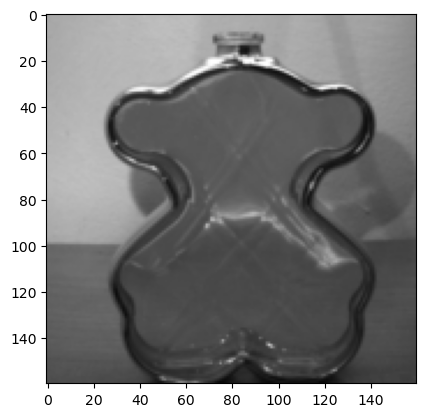

In [23]:
images, labels = next(iter(dataloader))
images = images.to(device)                        # Taking the entire batch to the available device
imgs_croped = transforms.functional.crop(images, 60, 30, 160, 160)
single_img = imgs_croped[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()
print(single_img_numpy.shape)
plt.imshow(single_img_numpy)

A sample of the generated images of the test set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(160, 160, 3)


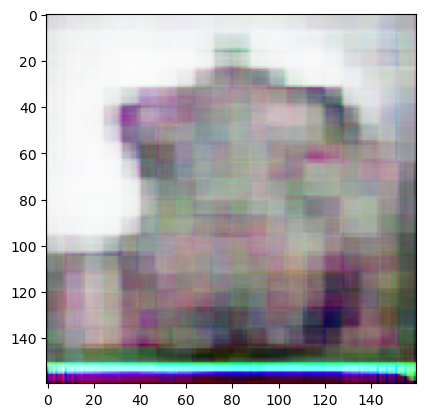

In [24]:
rec_image = netG(netE(imgs_croped)) 
single_img = rec_image[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()
print(single_img_numpy.shape)
plt.imshow(single_img_numpy)

See that the generated image looks not that good. It could be that the model need more iterations for training.

In [25]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        print(label)
        


 33%|███▎      | 2/6 [00:00<00:00,  8.41it/s]

tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])


 67%|██████▋   | 4/6 [00:00<00:00,  9.85it/s]

tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])


100%|██████████| 6/6 [00:00<00:00, 10.36it/s]

tensor([1, 1, 1, 1, 1])


Above, see that the last batch is the one that contains the anomaly images

In [26]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        if i == 0:
            idx           = (label == options_c)    
            # print("this is aux: ", aux)
        i = i+1
        


100%|██████████| 6/6 [00:00<00:00, 13.45it/s]


In [27]:
print("this is idx : ", idx)
print("this is the len of idx : ", len(idx))

this is idx :  tensor([True, True, True, True, True])
this is the len of idx :  5


Above, from the images of a batch of the test set, we assign "True" where the image is a non-anomaly image.

In [28]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        
        if i == 0:
            x = x.to(device)                        # Taking the entire batch to the available device
            imgs_croped = transforms.functional.crop(x, 60, 30, 160, 160)
            idx = (label == options_c)  
            aux = imgs_croped[idx]
            # print("this is aux: ", aux)
        i = i+1
        
print("this is idx : ", idx)
print("this is the len of aux : ", len(aux))

100%|██████████| 6/6 [00:00<00:00, 13.47it/s]

this is idx :  tensor([True, True, True, True, True])
this is the len of aux :  5


The variable "aux" is suppossed to contain the images that correspond to the digit zero

In [29]:
print("this is the shape of an element of aux : ", aux[0].shape)

this is the shape of an element of aux :  torch.Size([3, 160, 160])


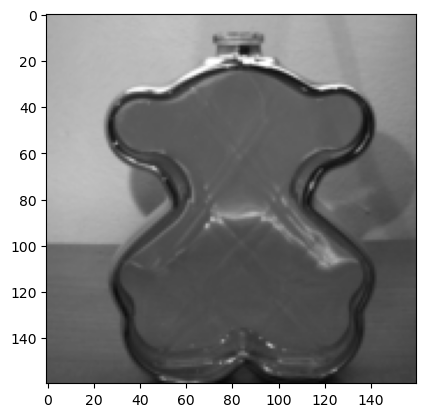

In [30]:
single_img = aux[2]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

In [31]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        
        if i == 0:
            x = x.to(device)                        # Taking the entire batch to the available device
            imgs_croped = transforms.functional.crop(x, 60, 30, 160, 160)
            idx = (label == options_c)  
            in_real.append(imgs_croped[idx])
            # print("this is aux: ", aux)
        i = i+1
        


100%|██████████| 6/6 [00:00<00:00, 13.64it/s]


In [32]:
print("this is the len of in_real : ", len(in_real))
print("this is the number of images that the only element of in_real contains : ", len(in_real[0]))

this is the len of in_real :  1
this is the number of images that the only element of in_real contains :  5


Now, testing to store the images from ALL the batches, not only one.

In [33]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        x = x.to(device)                        # Taking the entire batch to the available device
        imgs_croped = transforms.functional.crop(x, 60, 30, 160, 160)
        idx = (label == options_c)  
        in_real.append(imgs_croped[idx])
        # print("this is aux: ", aux)



100%|██████████| 6/6 [00:00<00:00, 13.54it/s]


In [34]:
print("this is the len of in_real : ", len(in_real))

this is the len of in_real :  6


In [35]:
for i in range(len(in_real)):
    print("this is the number of non-anomaly images that the 'in_real' variable contains : ", len(in_real[i]))

this is the number of non-anomaly images that the 'in_real' variable contains :  5
this is the number of non-anomaly images that the 'in_real' variable contains :  5
this is the number of non-anomaly images that the 'in_real' variable contains :  5
this is the number of non-anomaly images that the 'in_real' variable contains :  5
this is the number of non-anomaly images that the 'in_real' variable contains :  5
this is the number of non-anomaly images that the 'in_real' variable contains :  0


Above we can see the quantity of images of the non-anomaly images that each batch contains. It is as expected, some batches contains more non-anomalies than others

In [36]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        if i == 0:           
            x             = x.to(device)                        # Taking the entire batch to the available device
            imgs_croped = transforms.functional.crop(x, 60, 30, 160, 160)
            rec_image     = netG(netE(imgs_croped))                       # The result of the encoder model is fed to the generator model. The result is a batch of generated images
            d_input       = torch.cat((imgs_croped, rec_image), dim=0)    # Concatenation of the batch of images and their generated image. The result is of shape [120, 3, 64, 64]   
            print("this is the shape of d_input, the concatenation of x and rec_image: ", d_input.shape)  
            f_x, f_gx     = netD.extract_feature(d_input).chunk(2, 0)   
        i = i+1
        
print("this is f_x : ", f_x)
print("this is the shape of f_x : ", f_x.shape)


print("this is f_gx : ", f_gx)
print("this is the shape of f_gx : ", f_gx.shape)

  0%|          | 0/6 [00:00<?, ?it/s]

this is the shape of d_input, the concatenation of x and rec_image:  torch.Size([10, 3, 160, 160])


100%|██████████| 6/6 [00:12<00:00,  2.16s/it]

this is f_x :  tensor([[-3.2446, -4.9217, -4.9729,  ..., -7.6382, -7.7289, -6.5177],
        [-3.2257, -4.9077, -4.9544,  ..., -7.6430, -7.7316, -6.5140],
        [-3.1966, -4.8785, -4.9196,  ..., -7.6321, -7.7249, -6.4971],
        [-3.2038, -4.8840, -4.9248,  ..., -7.6348, -7.7278, -6.5023],
        [-3.1984, -4.8770, -4.9177,  ..., -7.6329, -7.7295, -6.4989]])
this is the shape of f_x :  torch.Size([5, 128000])
this is f_gx :  tensor([[-1.7634, -3.4706, -3.4386,  ..., -7.5136, -7.6792, -6.2127],
        [-1.7634, -3.4706, -3.4386,  ..., -7.5136, -7.6792, -6.2127],
        [-1.7634, -3.4706, -3.4386,  ..., -7.5136, -7.6792, -6.2127],
        [-1.7634, -3.4706, -3.4386,  ..., -7.5136, -7.6792, -6.2127],
        [-1.7634, -3.4706, -3.4386,  ..., -7.5136, -7.6792, -6.2127]])
this is the shape of f_gx :  torch.Size([5, 128000])


In [37]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        if i == 0:    
            bs            = x.size(0)       
            x             = x.to(device)                        # Taking the entire batch to the available device
            imgs_croped = transforms.functional.crop(x, 60, 30, 160, 160)
            rec_image     = netG(netE(imgs_croped))                       # The result of the encoder model is fed to the generator model. The result is a batch of generated images
            x0            = imgs_croped.reshape(imgs_croped.size(0),-1)
            x1            = rec_image.reshape([bs, OUTPUT_DIM])  
        i = i+1
        
print("the shape of hte images in the test set is: ", imgs_croped.shape)
print("the shape of rec_image is: ", rec_image.shape)
print("the shape of x0 is: ", x0.shape)
print("the shape of x1 is: ", x1.shape)

100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

the shape of hte images in the test set is:  torch.Size([5, 3, 160, 160])
the shape of rec_image is:  torch.Size([5, 3, 160, 160])
the shape of x0 is:  torch.Size([5, 76800])
the shape of x1 is:  torch.Size([5, 76800])


This line of code:

x0            = imgs_croped.reshape(imgs_croped.size(0),-1)

it used to be:

x0            = imgs_croped.view(imgs_croped.size(0),-1)

But it was changed due to an error. 

In [38]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        if i == 0:    
            bs            = x.size(0)       
            x             = x.to(device)                        # Taking the entire batch to the available device
            imgs_croped = transforms.functional.crop(x, 60, 30, 160, 160)
            rec_image     = netG(netE(imgs_croped))                       # The result of the encoder model is fed to the generator model. The result is a batch of generated images
            d_input       = torch.cat((imgs_croped, rec_image), dim=0)    # Concatenation of the batch of images and their generated image. The result is of shape [120, 3, 64, 64] 

            f_x, f_gx     = netD.extract_feature(d_input).chunk(2, 0)   

            x0            = imgs_croped.reshape(imgs_croped.size(0),-1)
            x1            = rec_image.reshape([bs, OUTPUT_DIM])  

            rec_diff      = (x1 - x0)**2
            rec_score     = rec_diff.mean(dim=1)

            feat_diff     = ((f_x - f_gx)**2)
            feat_score    = feat_diff.mean(dim=1)

            outlier_score = rec_score + options_alpha * feat_score

        i = i+1
        
print("the shape of rec_diff is: ", rec_diff.shape)
print("the shape of rec_score is: ", rec_score.shape)

print("the shape of feat_diff is: ", feat_diff.shape)
print("the shape of feat_score is: ", feat_score.shape)

print("the outlier_score is: ", outlier_score)
print("the shape of outlier_score is: ", outlier_score.shape)

100%|██████████| 6/6 [00:12<00:00,  2.16s/it]

the shape of rec_diff is:  torch.Size([5, 76800])
the shape of rec_score is:  torch.Size([5])
the shape of feat_diff is:  torch.Size([5, 128000])
the shape of feat_score is:  torch.Size([5])
the outlier_score is:  tensor([3.0687, 3.0448, 3.0168, 3.0205, 3.0142])
the shape of outlier_score is:  torch.Size([5])


In [39]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" refers to the batch of labels, which take numbers from 0 to 9
        bs            = x.size(0)                           # The element 0 of size of a batch of images is 60.           
        x             = x.to(device)                        # Taking the entire batch to the available device
        imgs_croped = transforms.functional.crop(x, 60, 30, 160, 160)
        rec_image     = netG(netE(imgs_croped))                       # The result of the encoder model is fed to the generator model. The result is a batch of generated images
        idx           = (label == options_c)                # List of true/false, true where the labels are equal to the normal class 
        in_real.append(imgs_croped[idx])                              # Grab those images from the batch of images, that correspond to a "zero" image
        in_rec.append(rec_image[idx])                       # Grab those images from the generated images, that correspond to a "zero" image
        idx           = (label != options_c)                # List of true/false, true where the labels are different to the normal class 
        out_real.append(imgs_croped[idx])                             # Grab images from the batch of images, that don't correspond to a "zero" image
        out_rec.append(rec_image[idx])                      # Grab images from the generated images, that don't correspond to a "zero" image




100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


In [40]:
print("in_real length is: ", len(in_real))
print("in_rec length is: ", len(in_rec))                
print("out_real length is: ", len(out_real))
print("out_rec length is: ", len(out_rec))


in_real length is:  6
in_rec length is:  6
out_real length is:  6
out_rec length is:  6


Let's see one of the images of the in_rec list. A reconstructed image that is generated from an original non-anomaly image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


this is the shape of an element of in_rec :  torch.Size([5, 3, 160, 160])


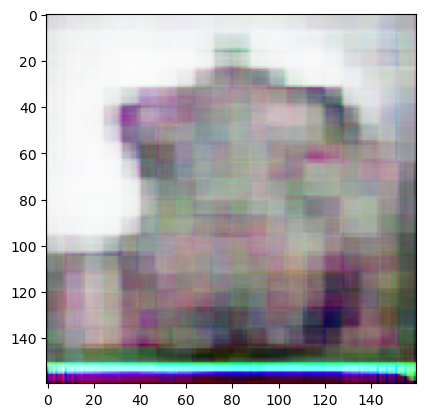

In [41]:
print("this is the shape of an element of in_rec : ", in_rec[0].shape)
single_batch = in_rec[0]
single_img = single_batch[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

Now, one image of the out_real list. This is an original anomaly image

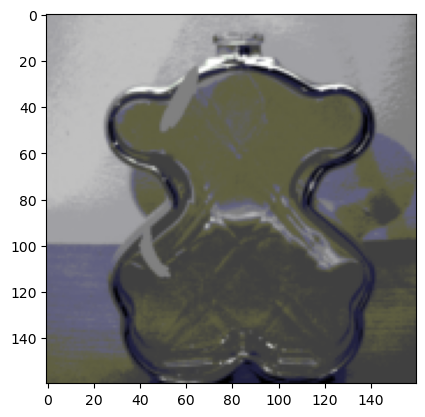

In [42]:
single_batch = out_real[5]
single_img = single_batch[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

And one image of the out_rec list. This is a reconstructed image generated upon an anomaly original image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


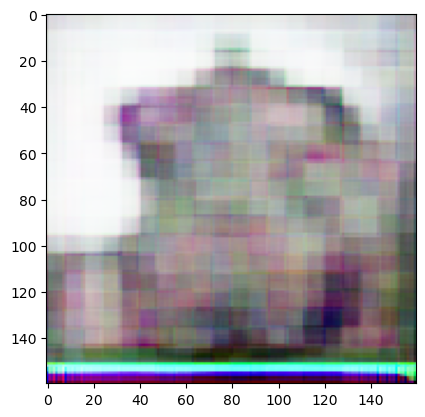

In [43]:
single_batch = out_rec[5]
single_img = single_batch[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

Before proceeding with the next part, that is concatenating the lists, we show the shape and len of the lists

In [44]:
print("in_real length is: ", len(in_real))
print("in_rec length is: ", len(in_rec))
print("out_real length is: ", len(out_real))
print("out_rec length is: ", len(out_rec))

print("in_real, one of the elemnts of this batch, has shape: ", in_real[0].shape)
print("in_rec, one of the elemnts of this batch, has shape: ", in_rec[0].shape)
print("out_real, one of the elemnts of this batch, has shape: ", out_real[0].shape)
print("out_rec, one of the elemnts of this batch, has shape: ", out_rec[0].shape)

in_real length is:  6
in_rec length is:  6
out_real length is:  6
out_rec length is:  6
in_real, one of the elemnts of this batch, has shape:  torch.Size([5, 3, 160, 160])
in_rec, one of the elemnts of this batch, has shape:  torch.Size([5, 3, 160, 160])
out_real, one of the elemnts of this batch, has shape:  torch.Size([0, 3, 160, 160])
out_rec, one of the elemnts of this batch, has shape:  torch.Size([0, 3, 160, 160])


Proceeding with the next part. Concatenating the lists

In [45]:
in_real = torch.cat(in_real, dim=0)[:32]
in_rec = torch.cat(in_rec, dim=0)[:32]
out_real = torch.cat(out_real, dim=0)[:32]
out_rec = torch.cat(out_rec, dim=0)[:32]

print("in_real length is: ", len(in_real))
print("in_rec length is: ", len(in_rec))
print("out_real length is: ", len(out_real))
print("out_rec length is: ", len(out_rec))

print("in_real, one of the elemnts of this batch, has shape: ", in_real[0].shape)
print("in_rec, one of the elemnts of this batch, has shape: ", in_rec[0].shape)
print("out_real, one of the elemnts of this batch, has shape: ", out_real[0].shape)
print("out_rec, one of the elemnts of this batch, has shape: ", out_rec[0].shape)

in_real length is:  25
in_rec length is:  25
out_real length is:  5
out_rec length is:  5
in_real, one of the elemnts of this batch, has shape:  torch.Size([3, 160, 160])
in_rec, one of the elemnts of this batch, has shape:  torch.Size([3, 160, 160])
out_real, one of the elemnts of this batch, has shape:  torch.Size([3, 160, 160])
out_rec, one of the elemnts of this batch, has shape:  torch.Size([3, 160, 160])


Above, it is concatenating and taking only the first 32 elements of them. As we only have 30 original images in total in this test set, it truncates at 25 and 5, the lengths of the images lists.

Continuing, we save the concatenation of "in_real" and "in_rec" in one image and the concatenation of "out_real" and "out_rec" in another one.

In [46]:
save_image(torch.cat((in_real, in_rec), dim=0), 'ForBottlesTrainings/real.png', normalize=True)
save_image(torch.cat((out_real, out_rec), dim=0),'ForBottlesTrainings/fake.png', normalize=True)

In [47]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
i = 0
with torch.no_grad():
    for (x, label) in tqdm(dataloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
           
        bs            = x.size(0)       
        x             = x.to(device)                        # Taking the entire batch to the available device
        imgs_croped = transforms.functional.crop(x, 60, 30, 160, 160)
        rec_image     = netG(netE(imgs_croped))                       # The result of the encoder model is fed to the generator model. The result is a batch of generated images
        d_input       = torch.cat((imgs_croped, rec_image), dim=0)    # Concatenation of the batch of images and their generated image. The result is of shape [120, 3, 64, 64] 

        f_x, f_gx     = netD.extract_feature(d_input).chunk(2, 0)   

        x0            = imgs_croped.reshape(imgs_croped.size(0),-1)
        x1            = rec_image.reshape([bs, OUTPUT_DIM])  

        rec_diff      = (x1 - x0)**2
        rec_score     = rec_diff.mean(dim=1)

        feat_diff     = ((f_x - f_gx)**2)
        feat_score    = feat_diff.mean(dim=1)

        outlier_score = rec_score + options_alpha * feat_score

        y_true.append(label)
        y_score.append(outlier_score.cpu())
        

100%|██████████| 6/6 [01:15<00:00, 12.53s/it]


In [48]:
print("y_true length is: ", len(y_true))
print("y_score length is: ", len(y_score))

print("y_true, one of the elemnts of this batch, has shape: ", y_true[0].shape)
print("y_score, one of the elemnts of this batch, has shape: ", y_score[0].shape)



y_true length is:  6
y_score length is:  6
y_true, one of the elemnts of this batch, has shape:  torch.Size([5])
y_score, one of the elemnts of this batch, has shape:  torch.Size([5])


In [49]:
print("y_true is: ", y_true)

y_true is:  [tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]), tensor([1, 1, 1, 1, 1])]


In [50]:
print("y_score is: ", y_score)

y_score is:  [tensor([3.0687, 3.0448, 3.0168, 3.0205, 3.0142]), tensor([3.0001, 3.0080, 3.0082, 3.1010, 3.0415]), tensor([3.0406, 3.0135, 3.0550, 2.9912, 2.9676]), tensor([3.0666, 2.7195, 2.7707, 2.9635, 3.1064]), tensor([3.1054, 3.1309, 3.1565, 3.1588, 3.1007]), tensor([2.9788, 2.9868, 2.9453, 2.9407, 2.8961])]


The above score is not that good yet. See that the score corresponding to the anomaly images are kind of the same as the non-anomaly ones.

In [51]:
y_score = np.concatenate(y_score)
y_true = np.concatenate(y_true)
y_true[y_true != options_c] = -1
y_true[y_true == options_c] = 1


In [52]:
print("y_true is: ", y_true)
print("y_true len is: ", len(y_true))

print("y_score is: ", y_score)
print("y_score len is: ", len(y_score))

y_true is:  [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1 -1 -1 -1 -1]
y_true len is:  30
y_score is:  [3.0686722 3.044838  3.0167603 3.020503  3.014197  3.0000982 3.0079913
 3.0082269 3.1010482 3.041548  3.040565  3.0135179 3.0549927 2.9911706
 2.9675627 3.0665753 2.719462  2.7707431 2.9635322 3.1063972 3.1053543
 3.130897  3.156505  3.1588407 3.1007073 2.9788074 2.9868183 2.9452684
 2.9406905 2.8961003]
y_score len is:  30


In [53]:
print('AUC = ', metrics.roc_auc_score(y_true, -y_score))

AUC =  0.112


## Checking the model performance with images

In [54]:
netG = GoodGenerator().to(device)
# netG.load_state_dict(torch.load(G_Model))                                     #For home laptop, using GPU
netG.load_state_dict(torch.load(G_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netG.eval()
netD = GoodDiscriminator().to(device)
# netD.load_state_dict(torch.load(D_Model))                                     #For home laptop, using GPU
netD.load_state_dict(torch.load(D_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netD.eval()
netE = Encoder(DIM, NOISE_SIZE).to(device)
# netE.load_state_dict(torch.load(E_Model))                                     #For home laptop, using GPU
netE.load_state_dict(torch.load(E_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netE.eval()

_, test_set = one_class_dataloader(options_c, 0, BATCH_SIZE)
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
with torch.no_grad():
    x, label = next(iter(test_set))
    
    bs            = x.size(0)
    x             = x.to(device)
    imgs_croped = transforms.functional.crop(x, 60, 30, 160, 160)
    rec_image     = netG(netE(imgs_croped))
    d_input       = torch.cat((imgs_croped, rec_image), dim=0)
    idx           = (label == options_c)
    in_real.append(imgs_croped[idx])
    in_rec.append(rec_image[idx])
    idx           = (label != options_c)
    out_real.append(imgs_croped[idx])
    out_rec.append(rec_image[idx])
    f_x, f_gx     = netD.extract_feature(d_input).chunk(2, 0)
    x0            = imgs_croped.reshape(imgs_croped.size(0),-1)
    x1            = rec_image.reshape([bs, OUTPUT_DIM]) 
    rec_diff      = (x1 - x0)**2
    rec_score     = rec_diff.mean(dim=1)
    feat_diff     = ((f_x - f_gx)**2)
    feat_score    = feat_diff.mean(dim=1)
    outlier_score = rec_score + options_alpha * feat_score
    y_true.append(label)
    y_score.append(outlier_score.cpu())
    
y_score = np.concatenate(y_score)
y_true = np.concatenate(y_true)
y_true[y_true != options_c] = -1
y_true[y_true == options_c] = 1



In [55]:
print("y_true is: ", y_true)
print("y_true has shape: ", y_true.shape)

print("y_score is: ", y_score)
print("y_score has shape: ", y_score.shape)

y_true is:  [1 1 1 1 1]
y_true has shape:  (5,)
y_score is:  [3.0686722 3.044838  3.0167603 3.020503  3.014197 ]
y_score has shape:  (5,)
